# Project Overview

This project aims to enhance the accuracy of detecting fraud in mobile financial transactions. By leveraging machine learning, the project seeks to predict fraudulent transactions with high precision. The goal is to develop a robust machine learning model to accurately identify fraudulent transactions in real-time , enabling the company to improve security, reduce financial losses, and gain insights into factors contributing to transaction fraud.

In [146]:
# Libraries for Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')
pd.set_option('display.float_format', '{:,.2f}'.format)

# To ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Models & Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [87]:
# Reading Dataset
df = pd.read_csv('Big_Fraud_Analysis.csv')

In [88]:
df.shape

(6362620, 11)

In [89]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,0
1,1,PAYMENT,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1,0
4,1,PAYMENT,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0,0


- **step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

- **type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

- **amount** - amount of the transaction in local currency.

- **nameOrig** - customer who started the transaction

- **oldbalanceOrg** - initial balance before the transaction

- **newbalanceOrig** - new balance after the transaction.

- **nameDest** - customer who is the recipient of the transaction

- **oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

- **newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

- **isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [91]:
# Checking null values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

No Null Values are present 

In [92]:
# Checking for duplicates
df.duplicated().sum()

np.int64(0)

No duplicate values are present

# Analysis

### isFraud

In [93]:
# Checking Target Column
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

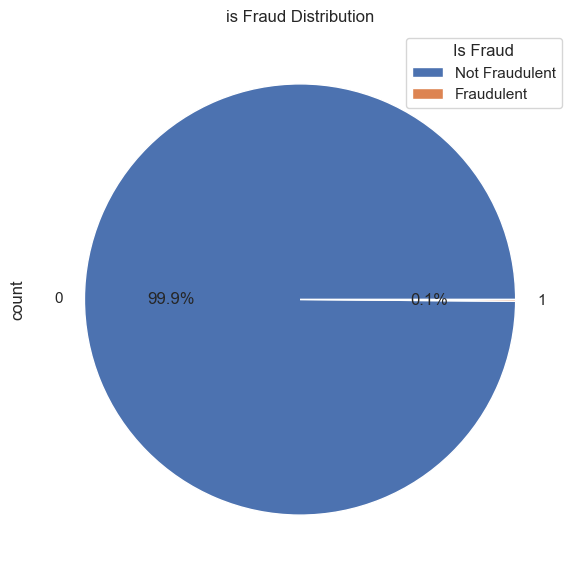

In [94]:
plt.figure(figsize=(7, 7))
df['isFraud'].value_counts().plot(kind = 'pie', autopct = '%0.1f%%', title= 'is Fraud Distribution')
plt.legend(['Not Fraudulent', 'Fraudulent'], title='Is Fraud')

Our target column show Immbalanced data, only 0.1% are fraudster, this can create problem in our ML model.

### isFlaggedFraud

<Axes: title={'center': 'isFlaggedFraud Distribution '}, ylabel='count'>

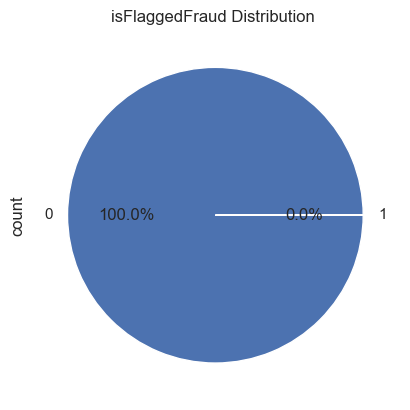

In [95]:
df['isFlaggedFraud'].value_counts().plot(kind = 'pie', autopct = '%0.1f%%', title = 'isFlaggedFraud Distribution ')

In [96]:
df.drop(columns= 'isFlaggedFraud', inplace= True)

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 485.4+ MB


### Type


In [98]:
df['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

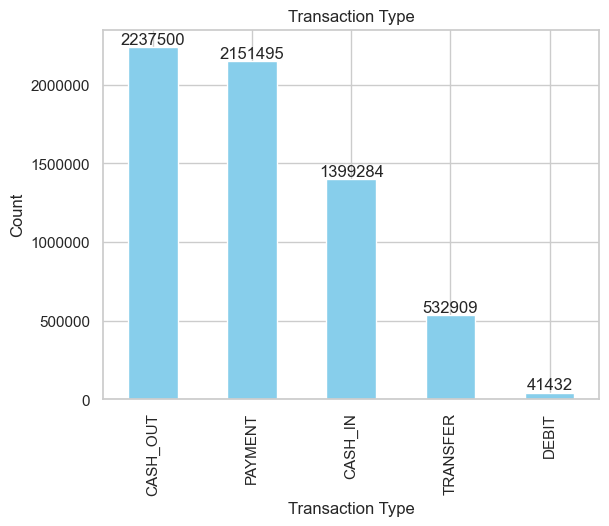

In [99]:
ax = df['type'].value_counts().plot(kind = 'bar', title= 'Transaction Type', color = 'skyblue')
plt.ticklabel_format(style = 'plain', axis= 'y')
ax.bar_label(ax.containers[0], fmt='%d')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

The chart shows that CASH_OUT and PAYMENT are the most common transaction types, while TRANSFER and DEBIT are much less frequent. This means most activity involves withdrawing money or making payments

### Relation b/w isFraud and Type

In [100]:
pd.crosstab(df['type'], df['isFraud'])

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


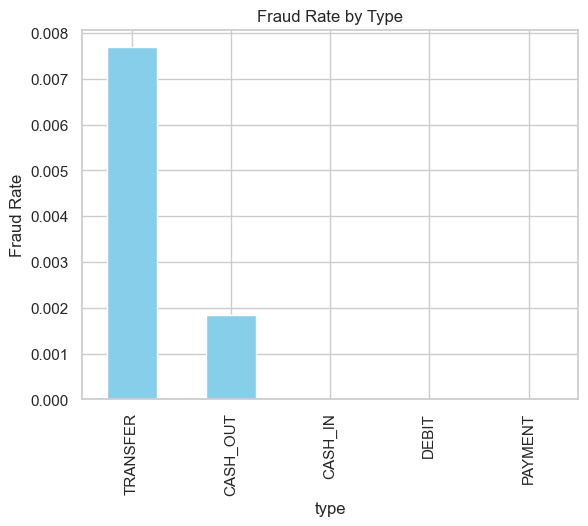

In [101]:
fraud_by_type = df.groupby('type')['isFraud'].mean().sort_values(ascending= False)
fraud_by_type.plot(kind = 'bar', title= 'Fraud Rate by Type', color = 'skyblue')
plt.ylabel('Fraud Rate')
plt.show()

Fraud rates are highest for TRANSFER transactions, followed by CASH_OUT. Other transaction types like PAYMENT, DEBIT, and CASH_IN have almost no fraud cases.

Fraudsters mainly target fund transfers and cash withdrawals, making these types most vulnerable to fraud activity

### Amount

In [102]:
df['amount'].describe()

count    6,362,620.00
mean       179,861.90
std        603,858.23
min              0.00
25%         13,389.57
50%         74,871.94
75%        208,721.48
max     92,445,516.64
Name: amount, dtype: float64

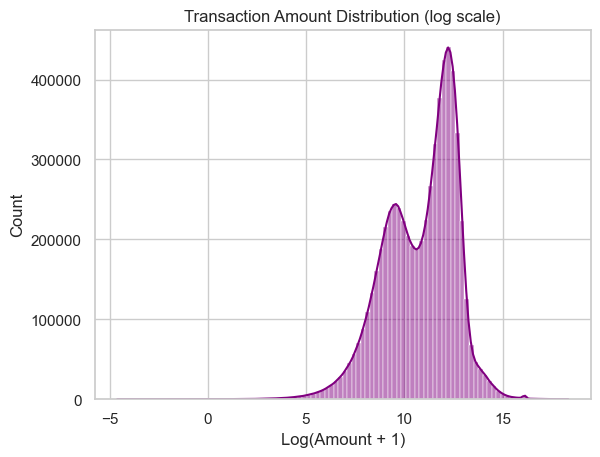

In [103]:
sns.histplot(np.log(df['amount']), bins = 100, kde = True, color = 'purple')
plt.title('Transaction Amount Distribution (log scale)')
plt.xlabel('Log(Amount + 1)') # Because log(0) is not defined
plt.show()

- Transaction amounts are highly skewed, with most values much smaller than the mean.
- Log transformation was used to reduce skewness, making patterns in data more visible and suitable for analysis.

The chart shows there are two common transaction sizes: many transactions are in one small value range, and many are in a larger value range. There are fewer transactions in between. This means people make both small and large payments often, but medium amounts are less common

### Relation b/w isFraud and Amount

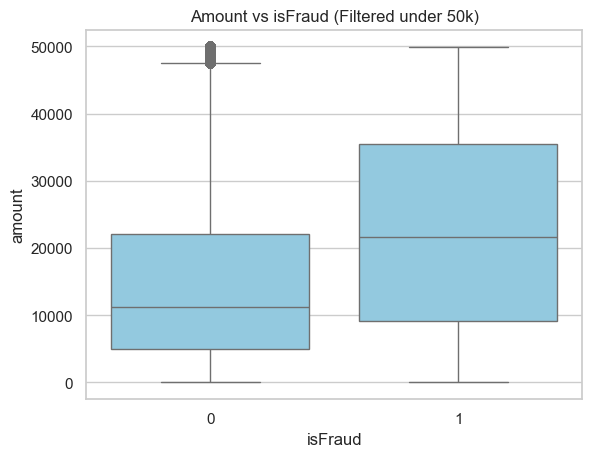

In [104]:
sns.boxplot(data = df[df['amount'] < 50000], x = 'isFraud', y = 'amount' , color = 'skyblue')
plt.title('Amount vs isFraud (Filtered under 50k)')
plt.show()

Fraud transactions under 50k have a notably higher median amount and wider spread than non-fraud ones, suggesting frauds attempt larger amounts on average

### Balance difference 


In [105]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')

In [106]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0
1,1,PAYMENT,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1
4,1,PAYMENT,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0


In [107]:
df['balanceDiffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balanceDiffDest'] = df['newbalanceDest'] - df['oldbalanceDest']

In [108]:
(df['balanceDiffOrig'] < 0).sum()

np.int64(1399253)

In [109]:
(df['balanceDiffDest'] < 0).sum()

np.int64(1238864)

A significant number of records show negative balance differences, which signals possible data quality issues or abnormal transaction flows 

# Zero Balance After Transaction

In [110]:
zero_after_transfer = df[
    (df['oldbalanceOrg'] > 0) &
    (df['newbalanceOrig'] == 0) &
    (df['type'].isin(['TRANSFER', 'CASH_OUT']))
]

In [111]:
len(zero_after_transfer)

1188074

### Step

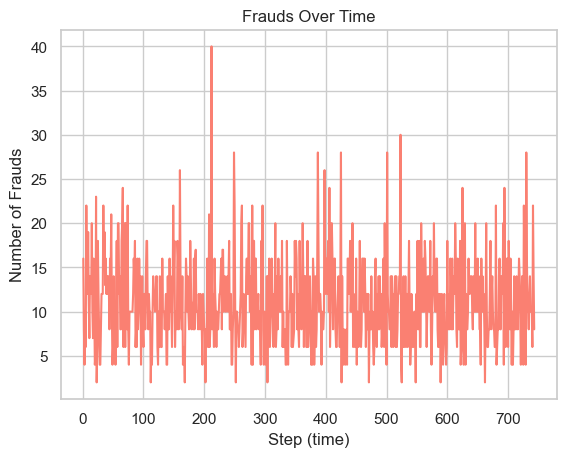

In [112]:
frauds_per_step = df[df['isFraud'] == 1]['step'].value_counts().sort_index()
plt.plot(frauds_per_step.index, frauds_per_step.values, color = 'salmon')
plt.xlabel('Step (time)')
plt.ylabel('Number of Frauds')
plt.title('Frauds Over Time')
plt.show()

Fraud is not dependent on time, So we will drop the Step column

In [113]:
df.drop(columns='step', inplace = True)

In [114]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,"9,839.64",0.00
1,PAYMENT,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0,"1,864.28",0.00
2,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,181.00,0.00
3,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1,181.00,"-21,182.00"
4,PAYMENT,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0,"11,668.14",0.00


### Top5 Most Frequent Senders and Receivers

In [115]:
top_senders = df['nameOrig'].value_counts().head(5)
top_senders

nameOrig
C1677795071    3
C1999539787    3
C724452879     3
C1976208114    3
C400299098     3
Name: count, dtype: int64

In [116]:
top_receivers = df['nameDest'].value_counts().head(5)
top_receivers

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
Name: count, dtype: int64

### Top 5 Fraud users

In [117]:
fraud_users = df[df['isFraud'] == 1]['nameOrig'].value_counts().head(5)
fraud_users

nameOrig
C1280323807    1
C1305486145    1
C840083671     1
C1420196421    1
C2101527076    1
Name: count, dtype: int64

### Fraud Distribution in Transfer and Cash Out

In [118]:
fraud_types = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])]
fraud_types['type'].value_counts()

type
CASH_OUT    2237500
TRANSFER     532909
Name: count, dtype: int64

In [119]:
pd.crosstab(fraud_types['type'], fraud_types['isFraud'])

isFraud,0,1
type,,
CASH_OUT,2233384,4116
TRANSFER,528812,4097


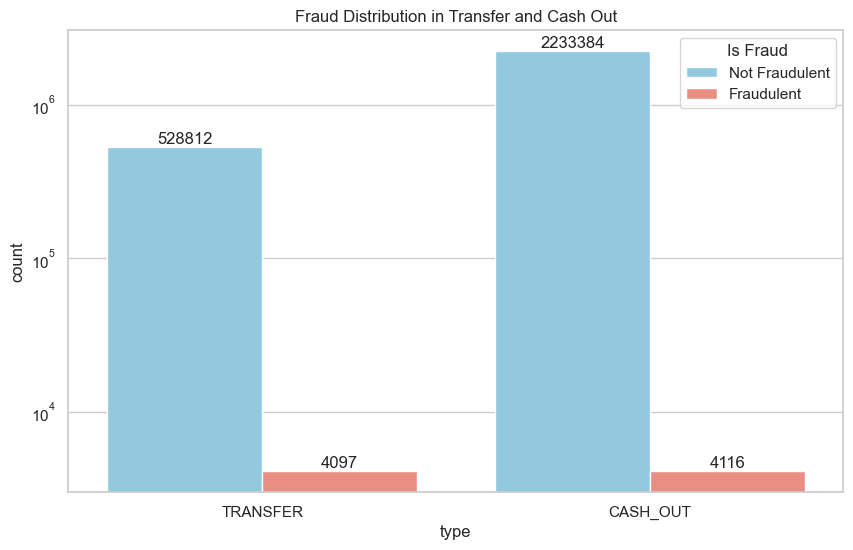

In [120]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data = fraud_types, x = 'type', hue = 'isFraud', palette={0: 'skyblue', 1: "salmon"})
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f')
plt.title('Fraud Distribution in Transfer and Cash Out')
plt.yscale('log')
plt.legend(['Not Fraudulent', 'Fraudulent'], title='Is Fraud')
plt.show()

the number of fraudulent transactions is much smaller than non-fraudulent ones for both TRANSFER and CASH_OUT types, making the dataset highly imbalanced.

### Transaction Amounts by Type and Fraud Status

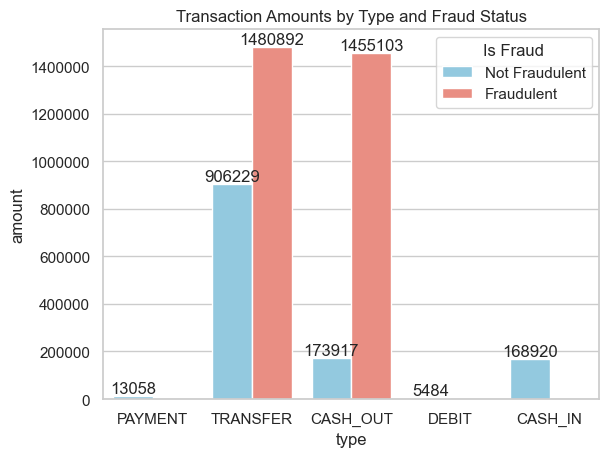

In [121]:
ax = sns.barplot(data = df, x = 'type', y = 'amount', hue = 'isFraud', ci = None, palette = ['skyblue', 'salmon'])
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f')
plt.ticklabel_format(style = 'plain', axis= 'y')
plt.title('Transaction Amounts by Type and Fraud Status')
plt.legend(['Not Fraudulent', 'Fraudulent'], title='Is Fraud')
plt.show()

**Key Insights**

- Fraudulent transactions are highly concentrated in 'TRANSFER' (₹1,480,892) and 'CASH_OUT' (₹1,455,103) types, showing these are the primary channels targeted by fraudsters.

- Legitimate 'TRANSFER' and 'CASH_OUT' transactions are much lower (₹906,229 and ₹173,917), confirming the need for stronger controls on these categories.

- 'PAYMENT', 'DEBIT', and 'CASH_IN' types show very little or no fraud, with total amounts under ₹170,000 each, making them low risk.

**Recommendation**: Focus fraud detection and prevention efforts on 'TRANSFER' and 'CASH_OUT' operations to maximize impact.

### Correlation

In [122]:
df.columns

Index(['type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'balanceDiffOrig', 'balanceDiffDest'],
      dtype='object')

In [123]:
corr = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']].corr()

In [124]:
corr

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.00,-0.00,-0.01,0.29,0.46,0.08
oldbalanceOrg,-0.00,1.00,1.00,0.07,0.04,0.01
newbalanceOrig,-0.01,1.00,1.00,0.07,0.04,-0.01
oldbalanceDest,0.29,0.07,0.07,1.00,0.98,-0.01
newbalanceDest,0.46,0.04,0.04,0.98,1.00,0.00
isFraud,0.08,0.01,-0.01,-0.01,0.00,1.00


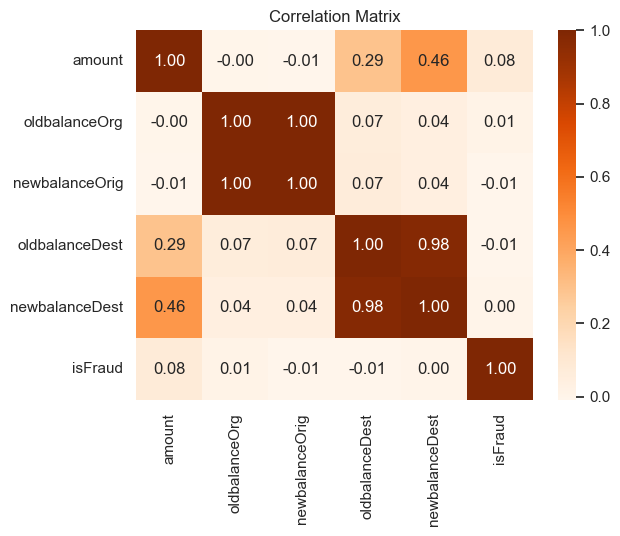

In [125]:
sns.heatmap(corr, annot = True, cmap = 'Oranges', fmt = '.2f')
plt.title('Correlation Matrix')
plt.show()

In [126]:
num_df = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]

In [127]:
num_df.describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,"6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00"
mean,"179,861.90","833,883.10","855,113.67","1,100,701.67","1,224,996.40"
std,"603,858.23","2,888,242.67","2,924,048.50","3,399,180.11","3,674,128.94"
min,0.00,0.00,0.00,0.00,0.00
25%,"13,389.57",0.00,0.00,0.00,0.00
50%,"74,871.94","14,208.00",0.00,"132,705.66","214,661.44"
75%,"208,721.48","107,315.18","144,258.41","943,036.71","1,111,909.25"
max,"92,445,516.64","59,585,040.37","49,585,040.37","356,015,889.35","356,179,278.92"


- No missing values in any column; all features have complete data.
- Highly skewed distributions, with the mean and standard deviation much higher than the median in all columns, indicating presence of extreme outliers.
- Majority of balances are zero
- Very large max values (up to 356 million), far above the 75th percentile, signaling rare but significant outlier transactions.

# Feature Engineering

In [128]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [129]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,"9,839.64",0.00
1,PAYMENT,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0,"1,864.28",0.00
2,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,181.00,0.00
3,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1,181.00,"-21,182.00"
4,PAYMENT,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0,"11,668.14",0.00


In [130]:
# Dropping columns
df_model = df.drop(['nameOrig', 'nameDest', 'balanceDiffOrig', 'balanceDiffDest'], axis = 1)
df_model.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,"9,839.64","170,136.00","160,296.36",0.00,0.00,0
1,PAYMENT,"1,864.28","21,249.00","19,384.72",0.00,0.00,0
2,TRANSFER,181.00,181.00,0.00,0.00,0.00,1
3,CASH_OUT,181.00,181.00,0.00,"21,182.00",0.00,1
4,PAYMENT,"11,668.14","41,554.00","29,885.86",0.00,0.00,0


## Removing Outliers from numerical column

In [131]:
categorical_col = ['type']
numerical_col = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

In [132]:
X = df_model.drop('isFraud', axis = 1)
y = df_model['isFraud']

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, stratify= y)

In [134]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numerical_col),
        ('cat', OneHotEncoder(drop = 'first'), categorical_col)
    ],
    remainder= 'drop'
)

In [135]:
def model_prediction(model):
    model.fit(X_train,y_train)
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)

    print('Accuracy on train : ', round(accuracy_score(y_train,y_train_pred)*100,2))
    print('Accuracy on test : ', round(accuracy_score(y_test,y_pred)*100,2))
    
    print("Classification Report is:\n",classification_report(y_test,y_pred))

    
    print(f"Confusion Matrix of model is:")
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(8,4))
    sns.heatmap(cm,annot=True,fmt="g",cmap="rocket")
    plt.show()

In [136]:
pipe_logReg = Pipeline([
    ('prep', preprocessor),
    ('lr', LogisticRegression(class_weight= 'balanced', max_iter=1000, random_state=42))
])

Accuracy on train :  94.52
Accuracy on test :  94.5
Classification Report is:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97   1906322
           1       0.02      0.94      0.04      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.94      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786

Confusion Matrix of model is:


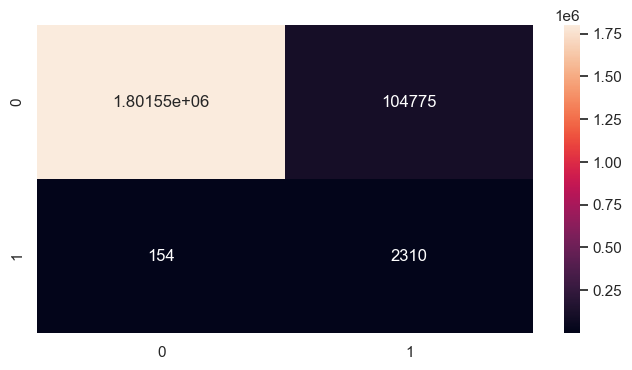

In [137]:
model_prediction(pipe_logReg)

Accuracy on train :  99.92
Accuracy on test :  99.92
Classification Report is:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.91      0.39      0.54      2464

    accuracy                           1.00   1908786
   macro avg       0.95      0.69      0.77   1908786
weighted avg       1.00      1.00      1.00   1908786

Confusion Matrix of model is:


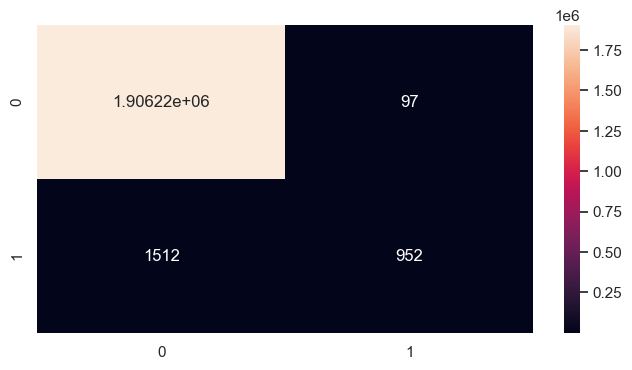

In [138]:
pipe_logReg2 = Pipeline([
    ('prep', preprocessor),
    ('lr', LogisticRegression(random_state=42))
])

model_prediction(pipe_logReg2)

In [151]:
pipe_dtree = Pipeline([
    ('prep', preprocessor),
    ('lr', DecisionTreeClassifier(class_weight= 'balanced', random_state= 42))
])

Accuracy on train :  100.0
Accuracy on test :  99.97
Classification Report is:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.90      0.86      0.88      2464

    accuracy                           1.00   1908786
   macro avg       0.95      0.93      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786

Confusion Matrix of model is:


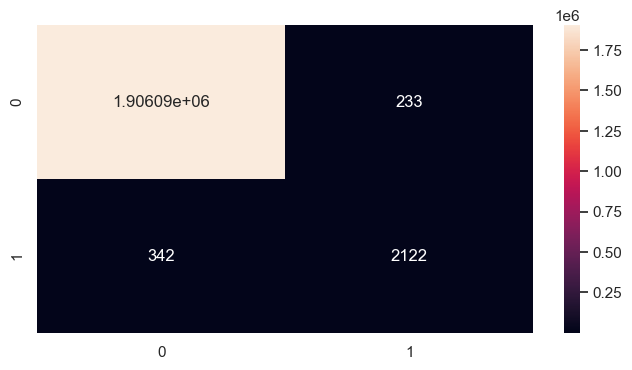

In [152]:
model_prediction(pipe_dtree)

In [153]:
pipe_dtree2 = Pipeline([
    ('prep', preprocessor),
    ('lr', DecisionTreeClassifier(random_state= 42))
])

Accuracy on train :  100.0
Accuracy on test :  99.97
Classification Report is:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.90      0.89      0.90      2464

    accuracy                           1.00   1908786
   macro avg       0.95      0.94      0.95   1908786
weighted avg       1.00      1.00      1.00   1908786

Confusion Matrix of model is:


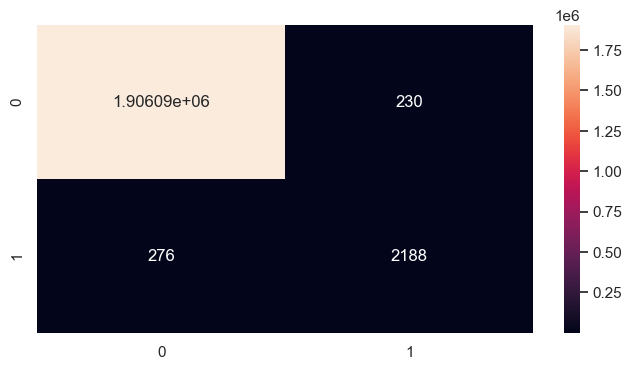

In [154]:
model_prediction(pipe_dtree2)

Accuracy on train :  99.94
Accuracy on test :  99.94
Classification Report is:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.85      0.67      0.75      2464

    accuracy                           1.00   1908786
   macro avg       0.92      0.83      0.87   1908786
weighted avg       1.00      1.00      1.00   1908786

Confusion Matrix of model is:


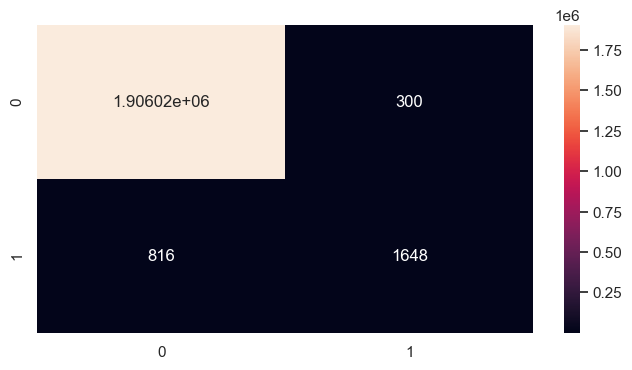

In [143]:
pipe_xgboost = Pipeline([
    ('prep', preprocessor),
    ('lr', XGBClassifier(random_state= 42))
])
model_prediction(pipe_xgboost)

Accuracy on train :  99.95
Accuracy on test :  99.95
Classification Report is:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.83      0.72      0.77      2464

    accuracy                           1.00   1908786
   macro avg       0.92      0.86      0.89   1908786
weighted avg       1.00      1.00      1.00   1908786

Confusion Matrix of model is:


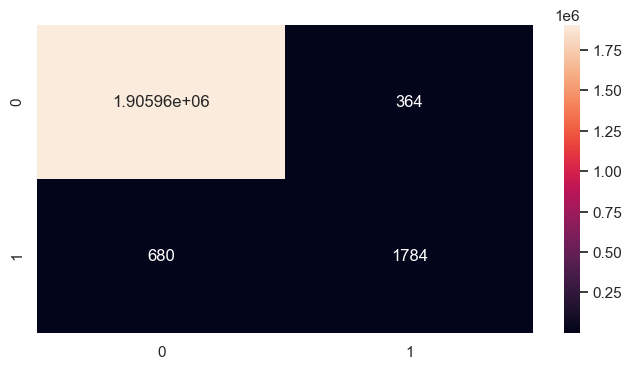

In [ ]:
pipe_xgboost2 = Pipeline([
    ('prep', preprocessor),
    ('lr', XGBClassifier(random_state= 42, scale_pos_weight=1, n_estimators=100, max_depth=10, use_label_encoder=False, eval_metric='logloss'))
])
model_prediction(pipe_xgboost2)

Accuracy on train :  99.88
Accuracy on test :  99.88
Classification Report is:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       1.00      0.08      0.15      2464

    accuracy                           1.00   1908786
   macro avg       1.00      0.54      0.58   1908786
weighted avg       1.00      1.00      1.00   1908786

Confusion Matrix of model is:


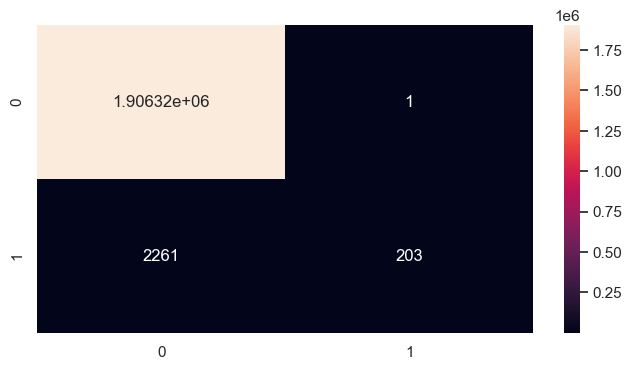

In [150]:
pipe_sgd = Pipeline([
    ('prep', preprocessor),
    ('clf', SGDClassifier(random_state= 42, loss='log_loss'))
])
model_prediction(pipe_sgd)

Accuracy on train :  93.4
Accuracy on test :  93.41
Classification Report is:
               precision    recall  f1-score   support

           0       1.00      0.93      0.97   1906322
           1       0.02      0.90      0.03      2464

    accuracy                           0.93   1908786
   macro avg       0.51      0.92      0.50   1908786
weighted avg       1.00      0.93      0.96   1908786

Confusion Matrix of model is:


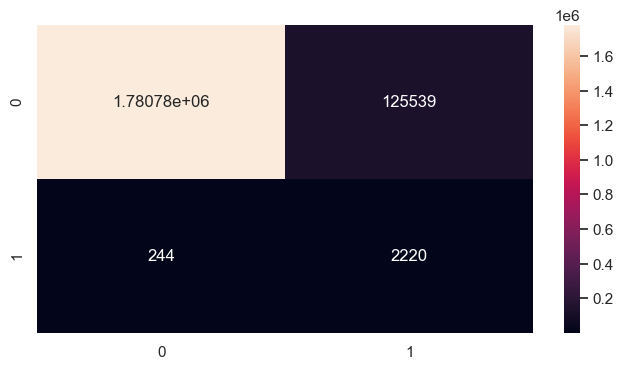

In [164]:
pipe_sgd2 = Pipeline([
    ('prep', preprocessor),
    ('clf', SGDClassifier(loss='log_loss', class_weight='balanced', max_iter=1000, random_state= 42))
])
model_prediction(pipe_sgd2)

# Conclusion 

- Between all the models Decision Tree Classifier is performing well
- Giving Precision of 90% and Recall of 88%, and in Fraud detection it is important to have good recall and a Good F1 score

# Dumping File

In [155]:
import joblib 

In [163]:
joblib.dump(pipe_dtree, 'fraud_detection_pipeline.pkl')

['fraud_detection_pipeline.pkl']